In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [5]:
%cd MyDrive/GE6371/InSAR_example/

/gdrive/MyDrive/GE6371/InSAR_example


In [6]:
!ls unwrappedPhase

20180129_20180105	       20180529_20180105
20180129_20180105.aux.xml      20180529_20180105.aux.xml
20180129_20180105.hdr	       20180529_20180105.hdr
20180129_20180105.png	       20180529_20180105.png
20180129_20180105.png.aux.xml  20180529_20180105.png.aux.xml
20180129_20180105.vrt	       20180529_20180105.vrt
20180210_20180117	       20180529_20180330
20180210_20180117.aux.xml      20180529_20180330.aux.xml
20180210_20180117.hdr	       20180529_20180330.hdr
20180210_20180117.png	       20180529_20180330.png
20180210_20180117.png.aux.xml  20180529_20180330.png.aux.xml
20180210_20180117.vrt	       20180529_20180330.vrt
20180222_20180129	       20180529_20180411
20180222_20180129.aux.xml      20180529_20180411.aux.xml
20180222_20180129.hdr	       20180529_20180411.hdr
20180222_20180129.png	       20180529_20180411.png
20180222_20180129.png.aux.xml  20180529_20180411.png.aux.xml
20180222_20180129.vrt	       20180529_20180411.vrt
20180306_20180210	       20180529_20180505
20180306_201802

In [7]:
# we will import some functions to work with
from makeTS import *

#### InSAR time-series analysis
For looking at earthquakes and other large deformation, often one or two interferograms will be sufficient to see the deformation. For smaller or long-term processes, InSAR time-series must be used. This introduces some more complexity into the processing because of the need to co-register interferograms and account for various noise sources. In the next example, you will use a simple InSAR time-series generator to look at deformation during the 2018 Kilauea volcano eruption on the Big Island of Hawaii. 

The 2018 Kilauea eruption resulted in uplift at the volcano because of extrusion of lava and injection of magma into the shallow subsurface, but the summit of the mountain deflated because magma moved from under the summit to the flank. You can read more about it __[here](https://www.usgs.gov/news/k-lauea-volcano-erupts)__. 

You will use the functions in "makeTS.py" to create a velocity map using the ARIA interferograms that I've downloaded. I've converted them to an aligned stack in the directory jlmd9g/interferogram_stack 

In [8]:
# makeTS is a module containing several functions, including dt2fracYear. We'll import them all!
ifgList = glob.glob('unwrappedPhase/*.vrt')
ccList = glob.glob('connectedComponents/*.vrt')

In [9]:
# print the list of interferograms
ifgList

['unwrappedPhase/20180129_20180105.vrt',
 'unwrappedPhase/20180210_20180117.vrt',
 'unwrappedPhase/20180222_20180129.vrt',
 'unwrappedPhase/20180306_20180210.vrt',
 'unwrappedPhase/20180318_20180222.vrt',
 'unwrappedPhase/20180330_20180105.vrt',
 'unwrappedPhase/20180330_20180306.vrt',
 'unwrappedPhase/20180411_20180105.vrt',
 'unwrappedPhase/20180411_20180318.vrt',
 'unwrappedPhase/20180423_20180330.vrt',
 'unwrappedPhase/20180505_20180411.vrt',
 'unwrappedPhase/20180517_20180423.vrt',
 'unwrappedPhase/20180529_20180105.vrt',
 'unwrappedPhase/20180529_20180330.vrt',
 'unwrappedPhase/20180529_20180411.vrt',
 'unwrappedPhase/20180529_20180505.vrt',
 'unwrappedPhase/20180610_20180330.vrt',
 'unwrappedPhase/20180610_20180411.vrt',
 'unwrappedPhase/20180610_20180517.vrt',
 'unwrappedPhase/20180622_20180411.vrt',
 'unwrappedPhase/20180622_20180529.vrt',
 'unwrappedPhase/20180704_20180610.vrt',
 'unwrappedPhase/20180716_20180622.vrt',
 'unwrappedPhase/20180728_20180529.vrt']

In [10]:
# First we will get the list of dates
datePairs, dates = getDates(ifgList)

In [11]:
# Look at the date pairs and dates
# what is the difference? Which one relates to interferograms and which relates to time-series? 
# Your answers here
datePairs[0]

(datetime.datetime(2018, 1, 29, 0, 0), datetime.datetime(2018, 1, 5, 0, 0))

In [12]:
# Next, use the dt2fracYear function to convert python datetimes to fractional dates
fracDates = np.array([dt2fracYear(d) for d in dates])

In [13]:
fracDates

array([2018.0109589 , 2018.04383562, 2018.07671233, 2018.10958904,
       2018.14246575, 2018.17534247, 2018.20821918, 2018.24109589,
       2018.2739726 , 2018.30684932, 2018.33972603, 2018.37260274,
       2018.40547945, 2018.43835616, 2018.47123288, 2018.50410959,
       2018.5369863 , 2018.56986301])

#### Interferograms to time-series
To estimate the displacement at each date, we use a G-matrix. This means that we will solve a linear system: 
**I = Gd**, where **I** is the stack of interferograms (actually, there is one stack for each pixel in each interferogram), **G** is called the "G-matrix" (or model matrix), and **d** is the displacement between each acquisition time and the one before. 

The columns of the **G**-matrix correspond to each acqiusition date, and the rows correspond to each interferogram. The elements of this matrix are simple: each interferogram gets a row, with a "-1" at the location of the second acquisition date, and a "+1" at the first acquisition date. Something like this:  
row 1: [0 0 0 0 -1 1 0 0]  
row 2: [0 0 0 0 0 0 -1 1]  
row 3: [-1 0 1 0 0 0 0 0]  
row 4: [-1 0 0 1 0 0 0 0]  
would represent a potential G-matrix. In this case, we have fewer interferograms then dates, but in most cases there will be more. We have to have, at a minimum, one interferogram using every acquisition date. 

For those of you familiar with linear algebra and inverse theory, this G-matrix is inverted to solve for the displacements at each time period. Since we have more interferograms than acquisition times, this is an _over-determined_ system, and we will solve for the best-fitting time-series that matches all of the interferograms. We could then go back to the interfergrams by differencing the displacements between the two corresponding acquisition times. 

In [14]:
# G itself is not related to the data; it only depends on the model (in this case, which dates are linked by which interferograms)
G = makeG(dates, datePairs)

In [15]:
# get the details about the size of the interferogram raster images: size, projection, and so forth
xSize, ySize, dType, geoProj, trans, noDataVal, Nbands = readRaster(ifgList[0])

Using band one for dataType


In [16]:
# read all the interferograms into memory
data = getData(ifgList,1)
print(data.shape) # this should be a big 3-d matrix with each interferogram

(24, 3156, 3805)


In [17]:
plt.imshow(data[10,...])

NameError: ignored

In [31]:
cc = getData(ccList,1)

In [41]:
cax = plt.imshow(cc[20])
cbar = plt.colorbar(cax)

#### Reference region
**InSAR is a relative measurement.** This is because the measurements are modulo $2\pi$, so we never know what the absolute displacements are without comparing to some other measurement, such as GPS. In order to create a time-series, we have to relate all the interferograms, so we have to create a "reference point" (or reference region) where all the interferograms are identical. The only way to do this is to subtract out the value of the reference point from each unwrapped interferogram **before** estimating the time-series. This is what "dereference" does in the code below. Passing "None" to refCenter will use the center of the image, but you can adjust this to fit your preferences if needed. The refCenter pixel will have zero displacement in the time-series, so you want to pick an area that is not deforming. 

In [19]:
data = dereference(data, taxis=0,refCenter=[2500,2000],refSize=10)

With the interferograms referenced to a common region, and the G-matrix for relating dates and interferograms, we can now solve for displacements through time!

In [20]:
# Go from interferograms to time-series
tsArray = makeTS(G, data, fracDates)

In [21]:
tsArray.shape

(18, 3156, 3805)

### Note: 
The native InSAR displacements are in radians. To convert to meters, we need to multiply the displacements by $\frac{\lambda}{-4\pi}$, where $\lambda$ is the radar wavelength (=0.056 meters, or 5.6 cm, for Sentinel 1). This assumes "date_2 - date_1". When we do "date_1 - date_2", then we don't use the negative sign: $\frac{\lambda}{4\pi}$. ARIA products use the "date_2 - date_1" convention. 

In [24]:
# The data is still in phase (radians) so we'll convert to meters
tsArray = convertRad2meters(tsArray, lam=0.056) # wavelength lam is 5.6 cm for Sentinel-1

The plot below will compare a pixel located on the volcano to one on the summit of the mountain caldera. During the eruption, the volcano inflated and erupted while the summit actually deflated due to magma moving out the side. 

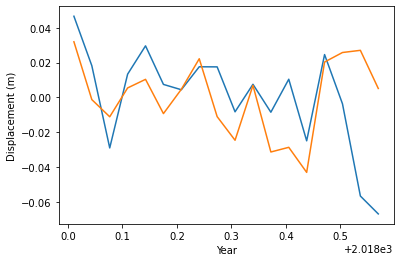

In [25]:
# We plot single pixels through time
plt.plot(fracDates, tsArray[:,2500,1000])  # this is a pixel to the west
plt.plot(fracDates, tsArray[:,2500,3000])  # this is a pixel to the east
plt.xlabel('Year')
plt.ylabel('Displacement (m)')
plt.show()

#### Velocity estimation
We can use the time-series to estimate various parameters of the event, such as the total or average rate of displacement. These can then be used to infer properties of the eruption, such as the volume of erupted fluid. We will estimate the mean line-of-sight velocity below. **Remember** that the line-of-sight for a satellite is mainly sensitive to vertical motion, so most of the displacements are vertical.

### Note:
InSAR displacements change sign depending on the order you create the interferograms. Each interferogram has two images that are differenced, so you can do "date_1 - date_2" _or_ "date_2 - date_1". 

In [26]:
# Compute the mean velocity by fitting a line
vel = findMeanVel(tsArray, fracDates, 0)

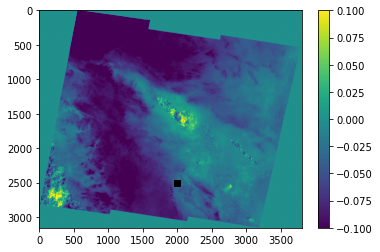

In [30]:
# Now we can plot the mean velocity throughout the period
cax = plt.imshow(vel, vmax=.1,vmin=-.1) # vmax and vmin adjusts the minimum and maximum color shown
plt.plot(2000, 2500, 'ks')
plt.colorbar()
plt.show()

In [ ]:
# save the data to an HDF5 file for use later
filename='ts.h5' # create your own filename with the path to your writeable folder, for example, 'jlmd9g/ts.h5'
writeTS2HDF5(tsArray, fracDates,vel,filename='ts.h5')